In [1]:
import numpy as np
import glob
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv(r'C:\Users\u23e00\NOx_prediction\data\raw\complete_data_29_10.csv')
df = df.drop('Unnamed: 0', axis=1)
df['NOx'] = df['GPiS_NO'] + df['GPiS_NO2']
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_AbsolutePressure,EFM_ExhaustGasDiffPress,EFM_ExhaustGasFlowMass,EFM_ExhaustGasFlowVol,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Barometric_Pressure_(PID_33),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Intake_Air_Temperature_(PID_0F),OBD_Vehicle_Speed_Sensor_(PID_0D),GPiS_NO2,accel,NOx
0,0.514287,31.845775,962.843895,21.151974,984.010010,0.00000,0.02200,0.000000,17.900000,14.9036,96.0,20.0,0.0,22.0,0.0,0.317213,NaN,0.831500
1,0.592000,31.918452,962.843895,21.181047,984.017822,0.00000,0.05398,0.000000,17.978001,14.9036,96.0,20.0,0.0,22.0,0.0,0.326000,0.0,0.918000
2,0.593300,31.894226,962.843895,21.151974,984.100220,0.00000,0.02171,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.330225,0.0,0.923525
3,0.595300,31.845775,962.843895,21.122906,984.210022,0.00000,-0.04421,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.336725,0.0,0.932025
4,0.596975,31.773098,962.843895,21.093832,984.210022,0.00000,-0.04077,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.343225,0.0,0.940200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496225,0.182830,17.213895,974.436712,16.646320,976.128540,-0.00300,-1.28990,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.883100,0.0,-0.700270
496226,0.171620,17.190055,974.675131,16.674925,976.190002,-0.00300,-1.38400,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.878390,0.0,-0.706770
496227,0.160620,17.213895,974.436712,16.674925,976.190002,-0.00300,-1.34970,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.873890,0.0,-0.713270
496228,0.149330,17.213895,974.675131,16.674925,976.197022,-0.00265,-1.21285,-0.000265,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.869390,0.0,-0.720060


In [3]:
channels = ['GPiS_NO','GPiS_NO2','NOx','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature',
    'EFM_AbsolutePressure','EFM_ExhaustGasDiffPress',
    'EFM_ExhaustGasFlowMass','EFM_ExhaustGasFlowVol','EFM_ExhaustGasTemp','OBD_Accelerator_Pedal_Position_D_(PID_49)',
    'OBD_Barometric_Pressure_(PID_33)','OBD_Engine_Coolant_Temperature_(PID_05)', 'OBD_Engine_RPM_(PID_0C)',
    'OBD_Intake_Air_Temperature_(PID_0F)','OBD_Vehicle_Speed_Sensor_(PID_0D)']

<AxesSubplot:>

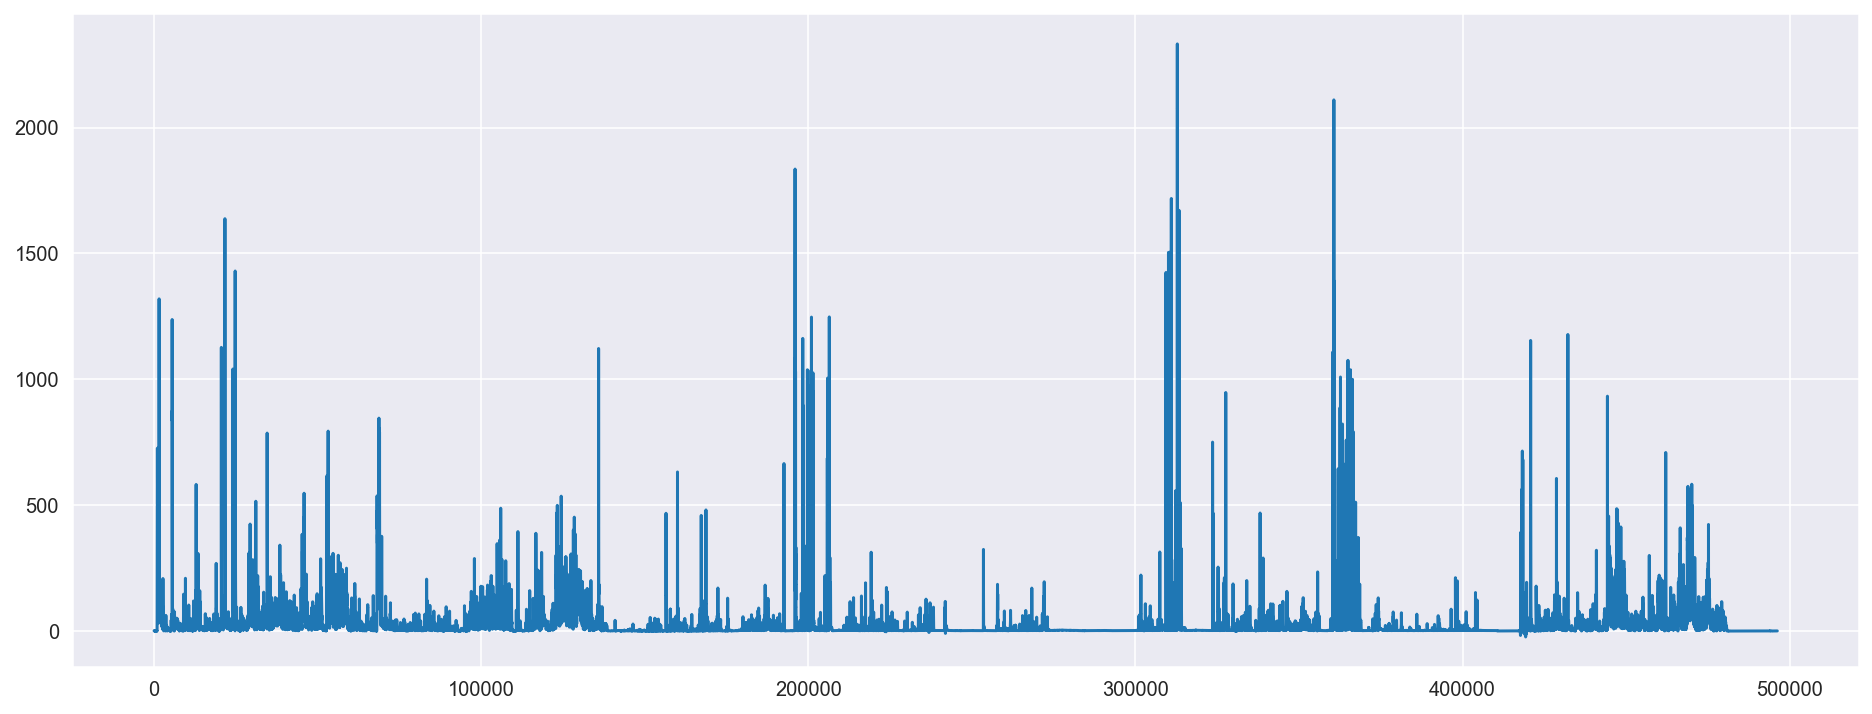

In [4]:
df['GPiS_NO'].plot()

<AxesSubplot:>

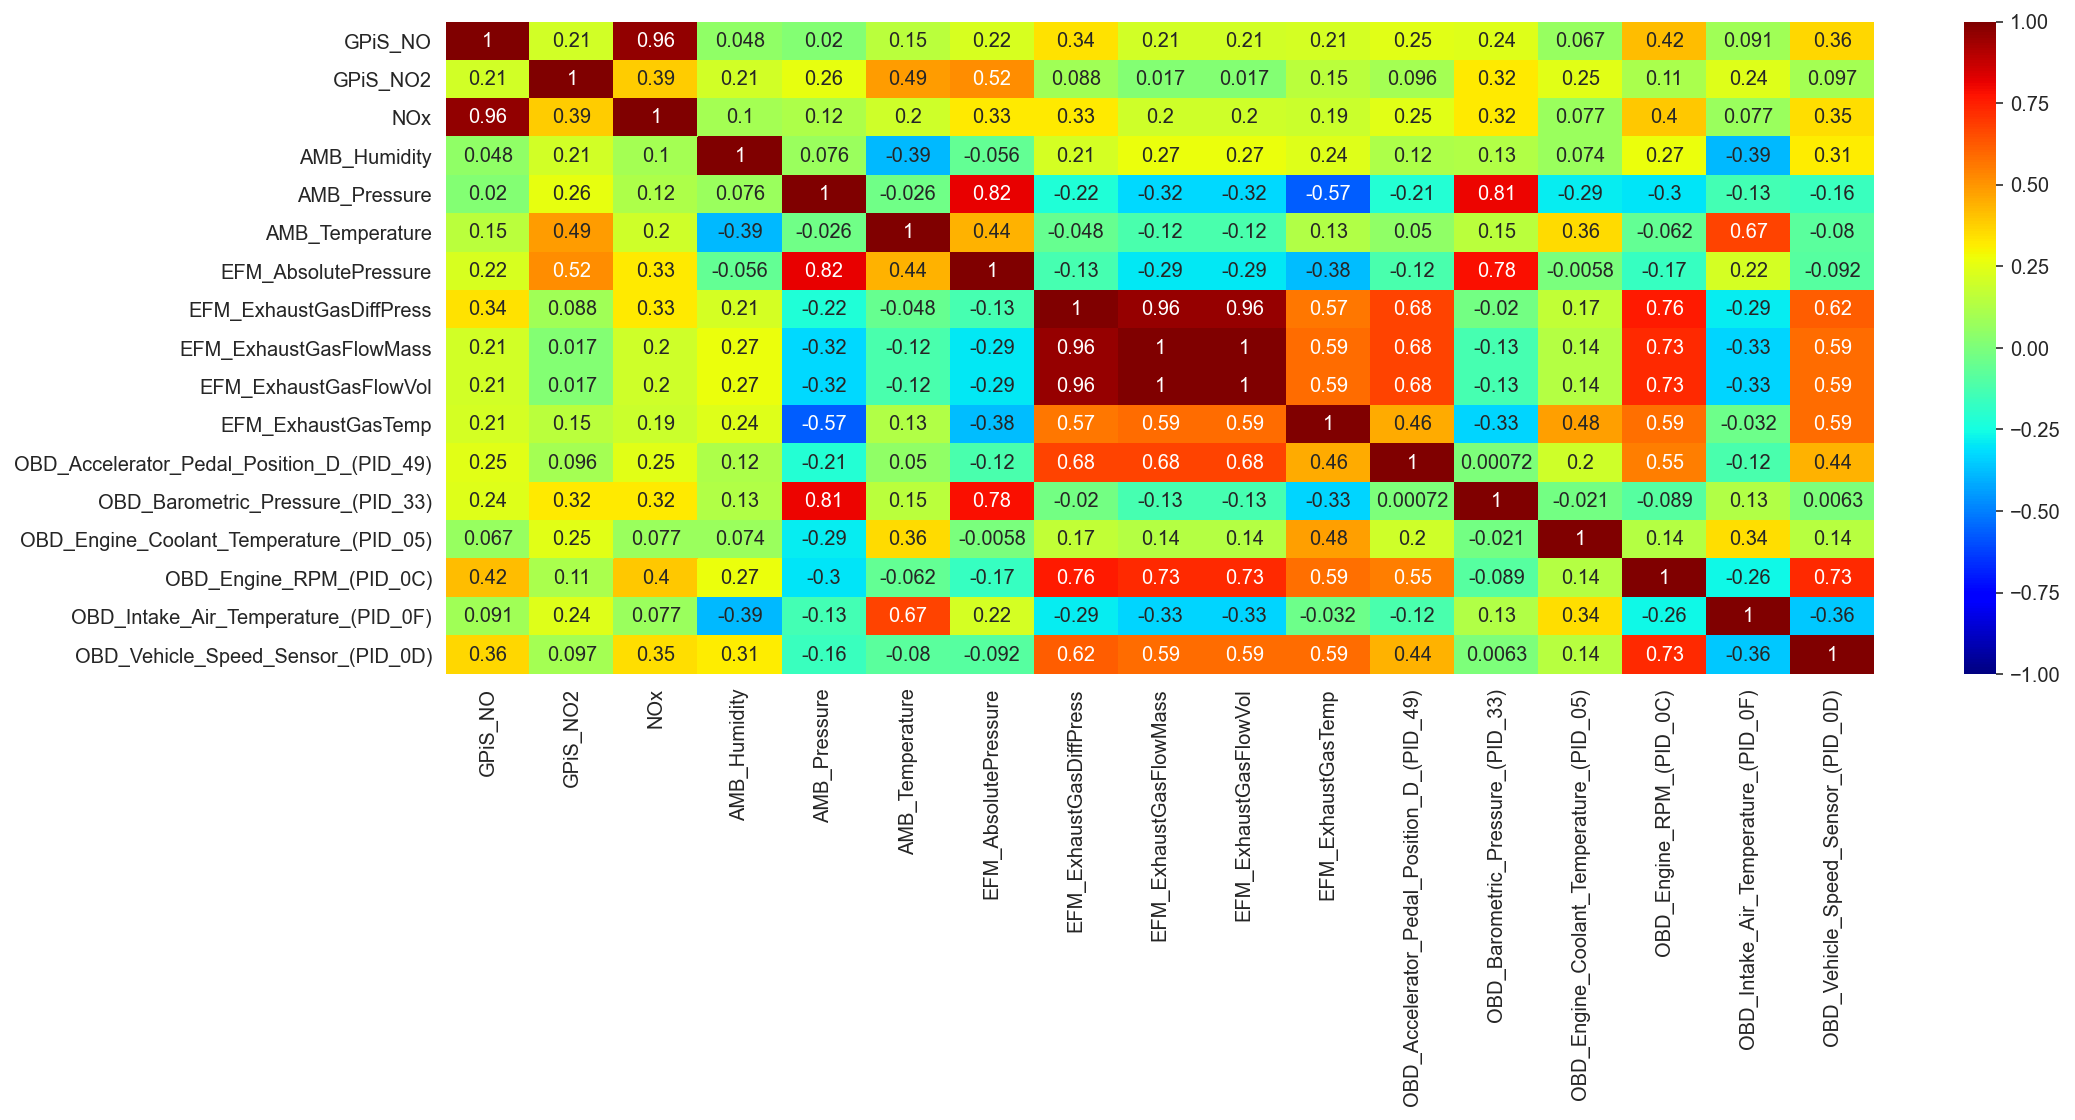

In [5]:
# plt.figure(figsize=(2,7))
sns.heatmap(pd.DataFrame(df[channels].corr(method='spearman')), annot = True, vmin=-1, vmax=1, center= 0, 
            cmap='jet')

In [6]:
df = df[(df['GPiS_NO']<500) &(df['GPiS_NO']>0)][:-2000]

<AxesSubplot:>

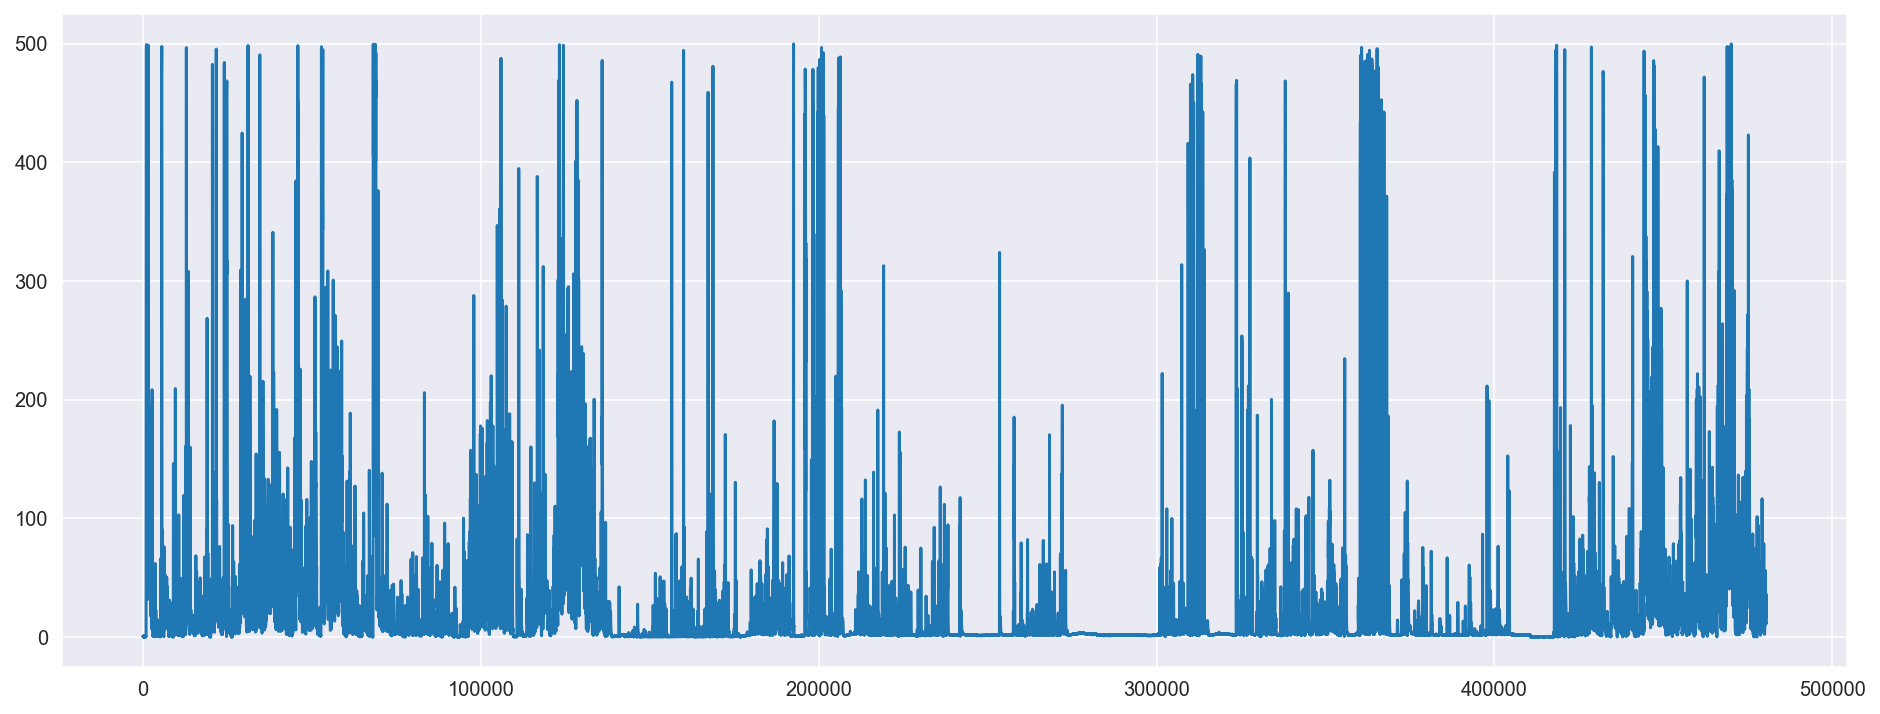

In [7]:
# df = df[:-11000]
df['GPiS_NO'].plot()

In [8]:
channels_model = ['GPiS_NO','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature','EFM_ExhaustGasTemp',
                  'OBD_Accelerator_Pedal_Position_D_(PID_49)','OBD_Engine_Coolant_Temperature_(PID_05)',
                  'OBD_Engine_RPM_(PID_0C)','OBD_Vehicle_Speed_Sensor_(PID_0D)','accel']

In [9]:
df = df[channels_model]
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
0,0.514287,31.845775,962.843895,21.151974,17.900000,14.903600,20.0,0.00,0.0,NaN
1,0.592000,31.918452,962.843895,21.181047,17.978001,14.903600,20.0,0.00,0.0,0.0
2,0.593300,31.894226,962.843895,21.151974,18.100000,14.903600,20.0,0.00,0.0,0.0
3,0.595300,31.845775,962.843895,21.122906,18.100000,14.903600,20.0,0.00,0.0,0.0
4,0.596975,31.773098,962.843895,21.093832,18.100000,14.903600,20.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
480447,18.639870,42.341800,976.820755,-4.895972,68.288002,18.820801,95.0,1215.00,26.0,0.0
480448,17.270870,42.341800,976.820755,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480449,17.113434,42.365642,977.059174,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480450,16.955997,42.341800,976.820755,-4.867365,68.400002,21.173401,95.0,1215.00,26.0,0.0


In [10]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<AxesSubplot:title={'center':'NO Emission'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

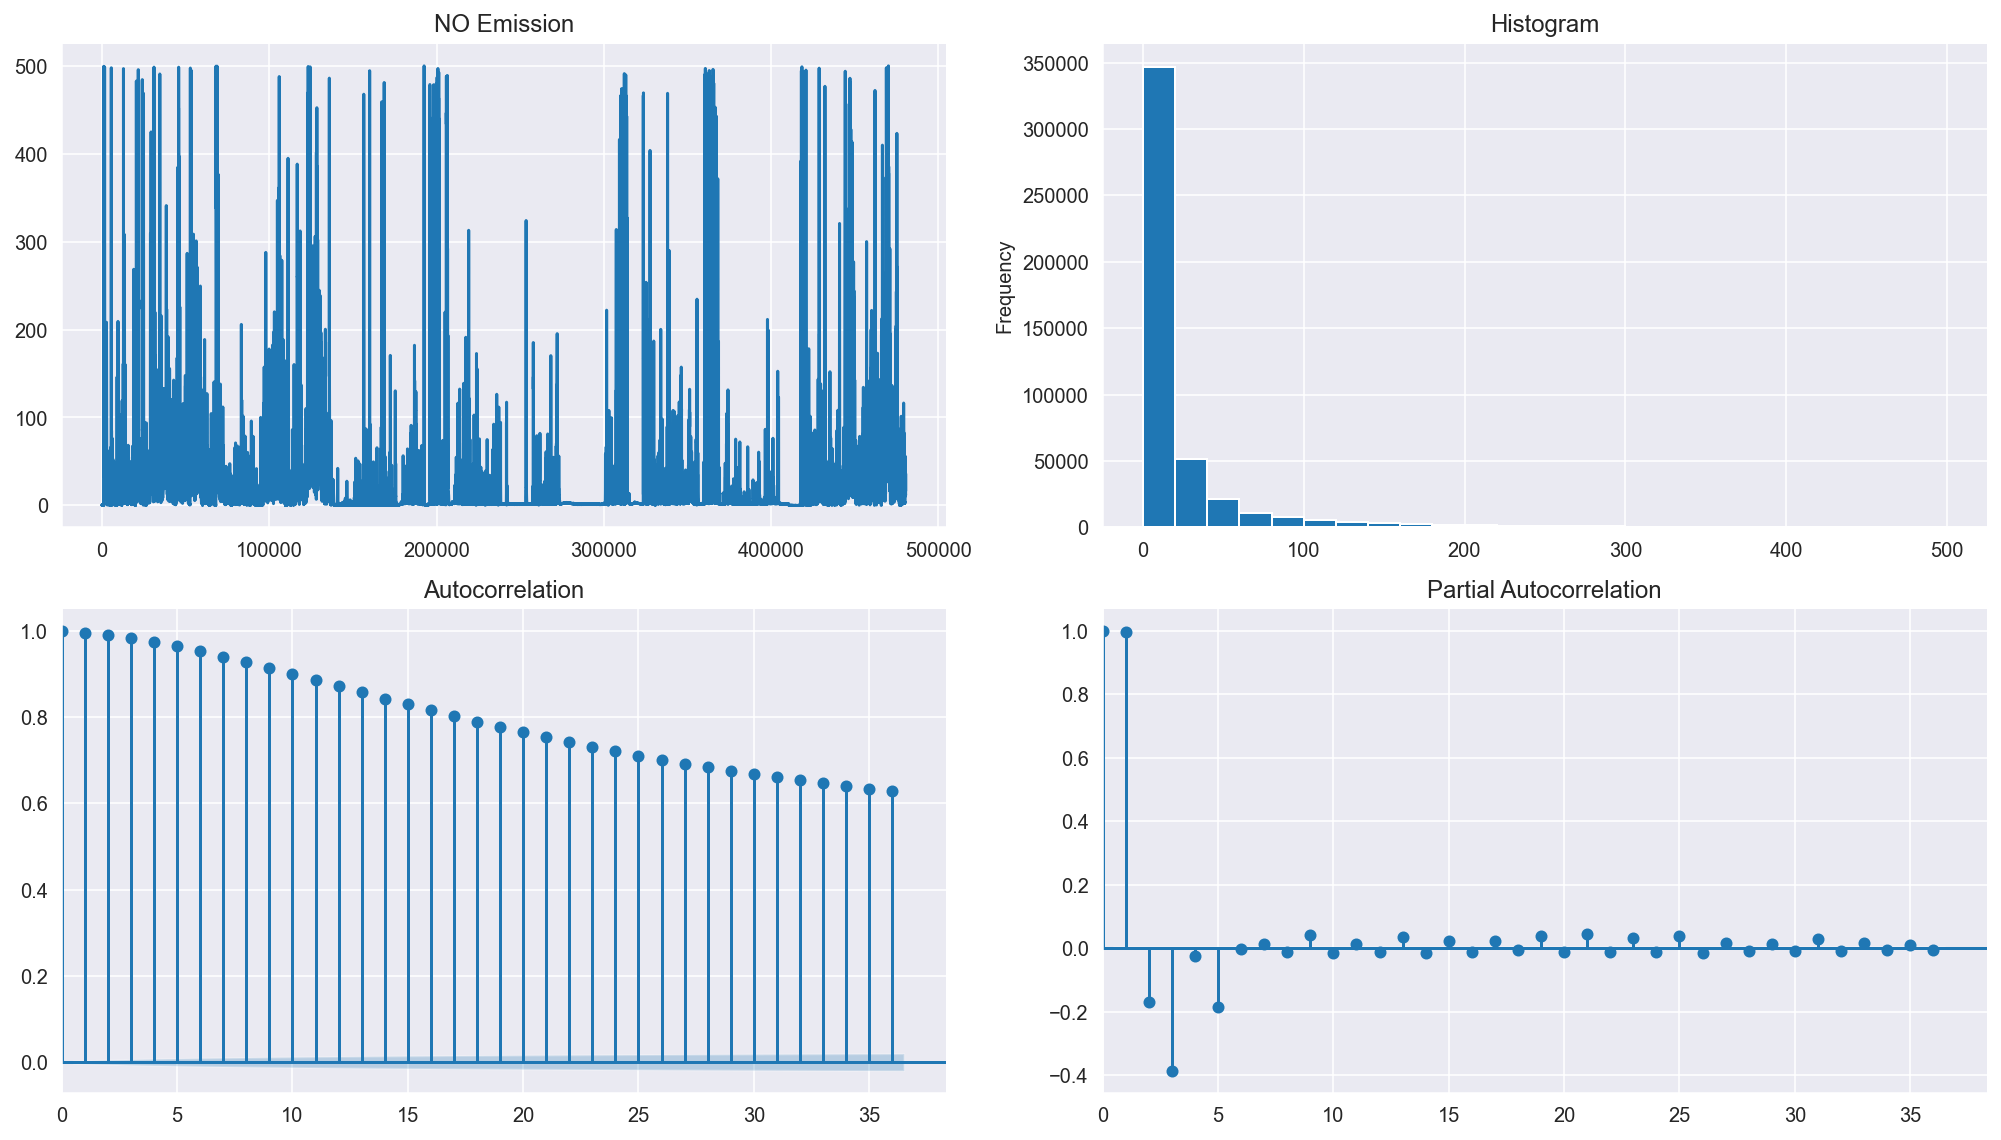

In [11]:
tsplot(df['GPiS_NO'], title='NO Emission', lags=36)

In [12]:
# load dataset
data = df.dropna()
values = data.values
values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [13]:
train_percent = .90

In [14]:
values.shape

(464996, 10)

In [15]:
# convert time-series data to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 1)
    if flag==1 :
        print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(train_percent*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    print(test_X.shape)
    return train_X, train_y, test_X, test_y

In [17]:
# Implementing Linear Regression method
def LinearReg(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [18]:
# Implementing Lasso Regression method
def RidgeRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Ridge()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [19]:
# Implementing Lasso Regression method
def LassoRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Lasso()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [20]:
# plot 2 lines
def plot(y1,y2,title):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    plt.xlabel('Index') 
    plt.ylabel('NO Emission (ppm)') 
    plt.title(title) 
    plt.legend()    
    plt.show()

In [21]:
MSE = {}
MAE = {}

   var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)   var3(t-2)  \
3   0.593300   0.595300  31.918451  31.894226  31.845774  962.843872   
4   0.595300   0.596975  31.894226  31.845774  31.773098  962.843872   
5   0.596975   0.598475  31.845774  31.773098  31.797323  962.843872   
6   0.598475   0.600300  31.773098  31.797323  31.845774  962.601624   
7   0.600300   0.602300  31.797323  31.845774  31.821548  962.843872   

    var3(t-1)  var4(t-3)  var4(t-2)  var4(t-1)  var5(t-2)  var5(t-1)  \
3  962.843872  21.181047  21.151974  21.122906  18.100000  18.100000   
4  962.843872  21.151974  21.122906  21.093832  18.100000  18.100000   
5  962.601624  21.122906  21.093832  21.122906  18.100000  18.100000   
6  962.843872  21.093832  21.122906  21.093832  18.100000  18.021999   
7  962.843872  21.122906  21.093832  21.181047  18.021999  17.900000   

   var6(t-3)  var6(t-2)  var6(t-1)  var7(t-2)  var7(t-1)  var8(t-3)  \
3    14.9036    14.9036    14.9036       20.0       20.0       

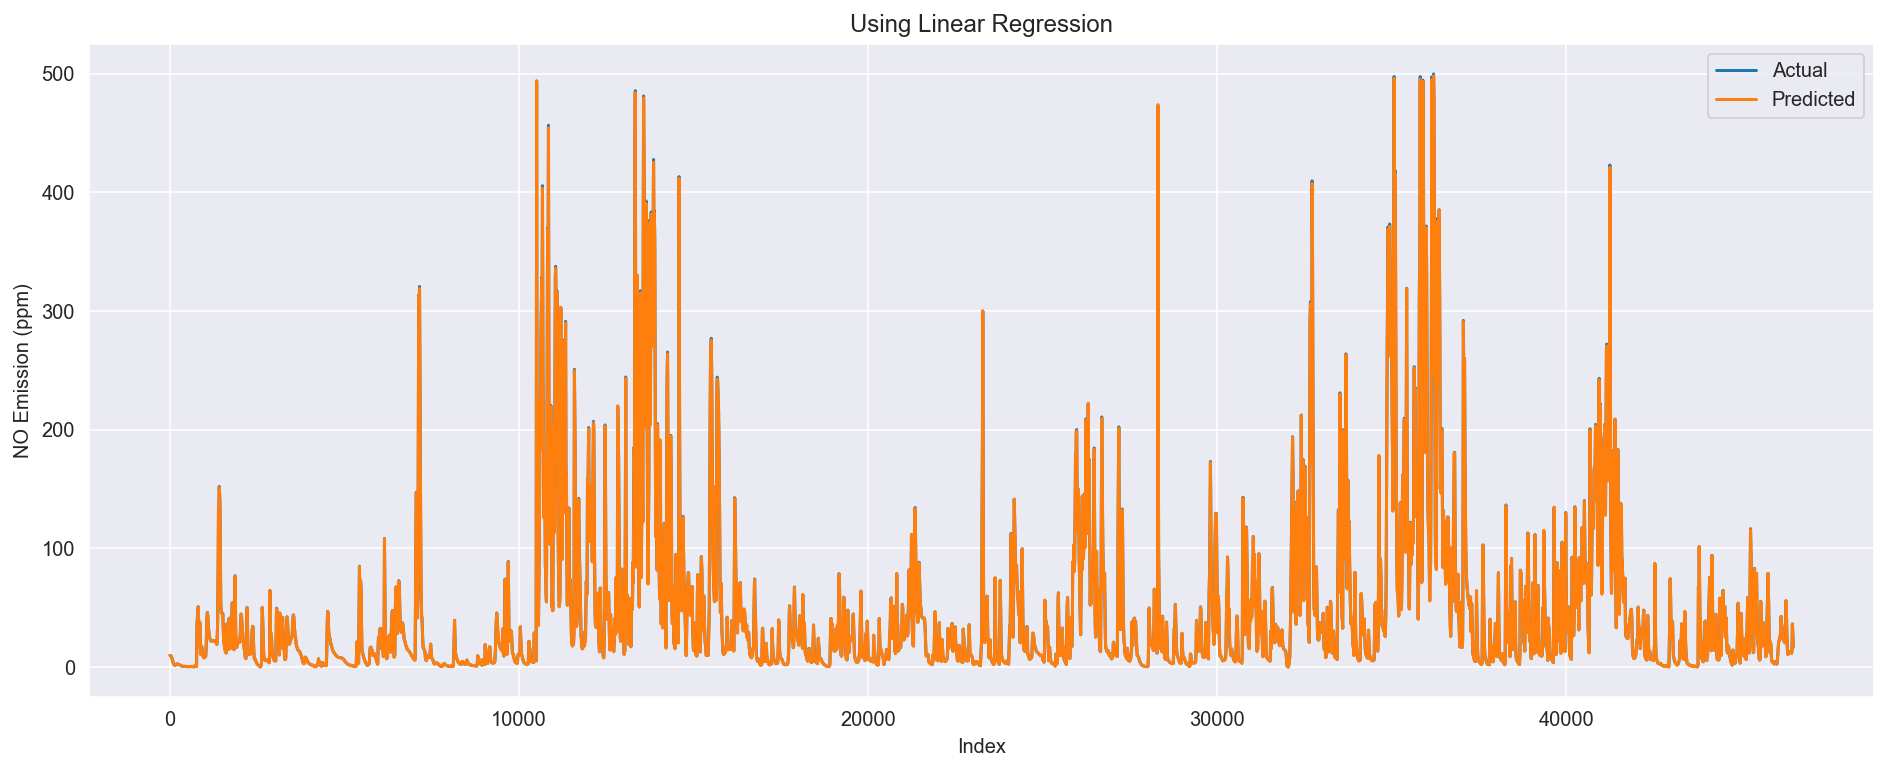

In [22]:
# Call Linear Regression model
# n_lag = [2,  3,  4,  5,  6,  7,  8,  9, 10]
n_lag = []
n_features = data.shape[1]
for i in range(0,n_features):
    if i%2==0:
        n_lag.append(2)
    else:
        n_lag.append(3)
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(values, n_lag, n_features,1)
print("MSE for Linear Regression method: " + str(MSE['LinearRegression']))
print("MAE for Linear Regression method: " + str(MAE['LinearRegression']))
plot(test, prediction, 'Using Linear Regression')

In [23]:
pd.DataFrame(values)[:10]

,0,1,2,3,4,5,6,7,8,9
0,0.592000,31.918451,962.843872,21.181047,17.978001,14.9036,20.0,0.0,0.0,0.0
1,0.593300,31.894226,962.843872,21.151974,18.100000,14.9036,20.0,0.0,0.0,0.0
2,0.595300,31.845774,962.843872,21.122906,18.100000,14.9036,20.0,0.0,0.0,0.0
3,0.596975,31.773098,962.843872,21.093832,18.100000,14.9036,20.0,0.0,0.0,0.0
4,0.598475,31.797323,962.601624,21.122906,18.100000,14.9036,20.0,0.0,0.0,0.0
5,0.600300,31.845774,962.843872,21.093832,18.021999,14.9036,20.0,0.0,0.0,0.0
6,0.602300,31.821548,962.843872,21.181047,17.900000,14.9036,20.0,0.0,0.0,0.0
7,0.604300,31.797323,962.843872,21.093832,17.900000,14.9036,20.0,0.0,0.0,0.0
8,0.606300,31.845774,962.601624,21.093832,17.900000,14.9036,20.0,0.0,0.0,0.0
9,0.608150,31.845774,962.601624,21.093832,17.900000,14.9036,20.0,0.0,0.0,0.0


(418496, 25) 418496 (418496,)
(46497, 25)
MSE for Lasso Regression method: 9.339019
MAE for Lasso Regression method: 1.3466644


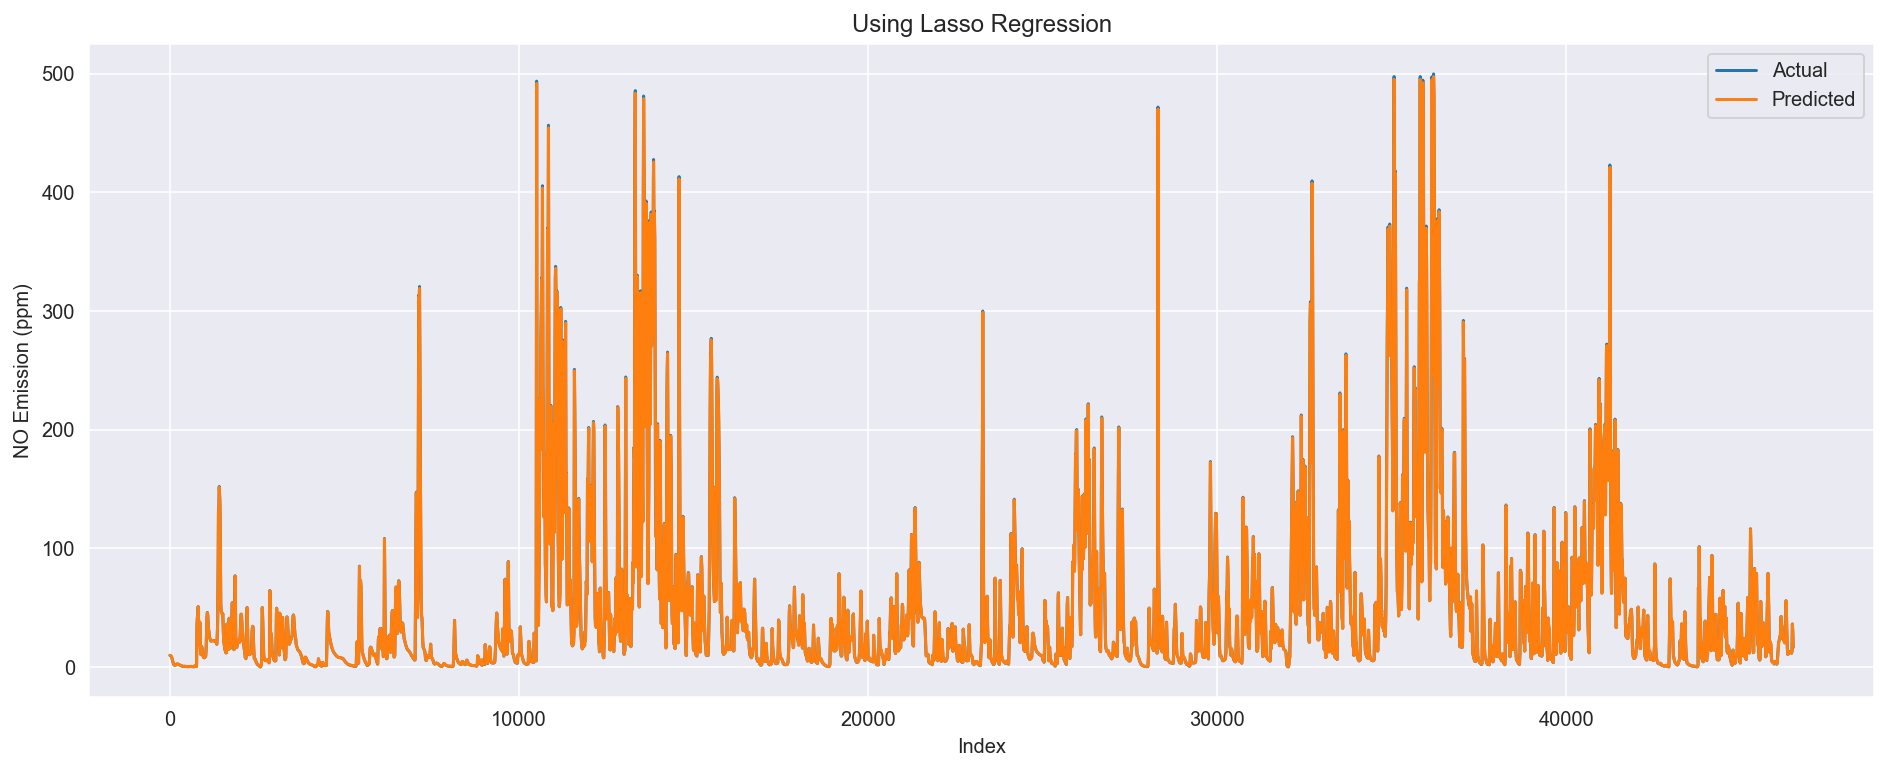

In [24]:
# Call Lasso Regression model
prediction, MSE['LassoRegression'], MAE['LassoRegression'], test = LassoRegression(values, n_lag, n_features,0)
print("MSE for Lasso Regression method: " + str(MSE['LassoRegression']))
print("MAE for Lasso Regression method: " + str(MAE['LassoRegression']))
plot(test, prediction, 'Using Lasso Regression')

(418496, 25) 418496 (418496,)
(46497, 25)
MSE for Ridge Regression method: 7.6468515
MAE for Ridge Regression method: 1.199085


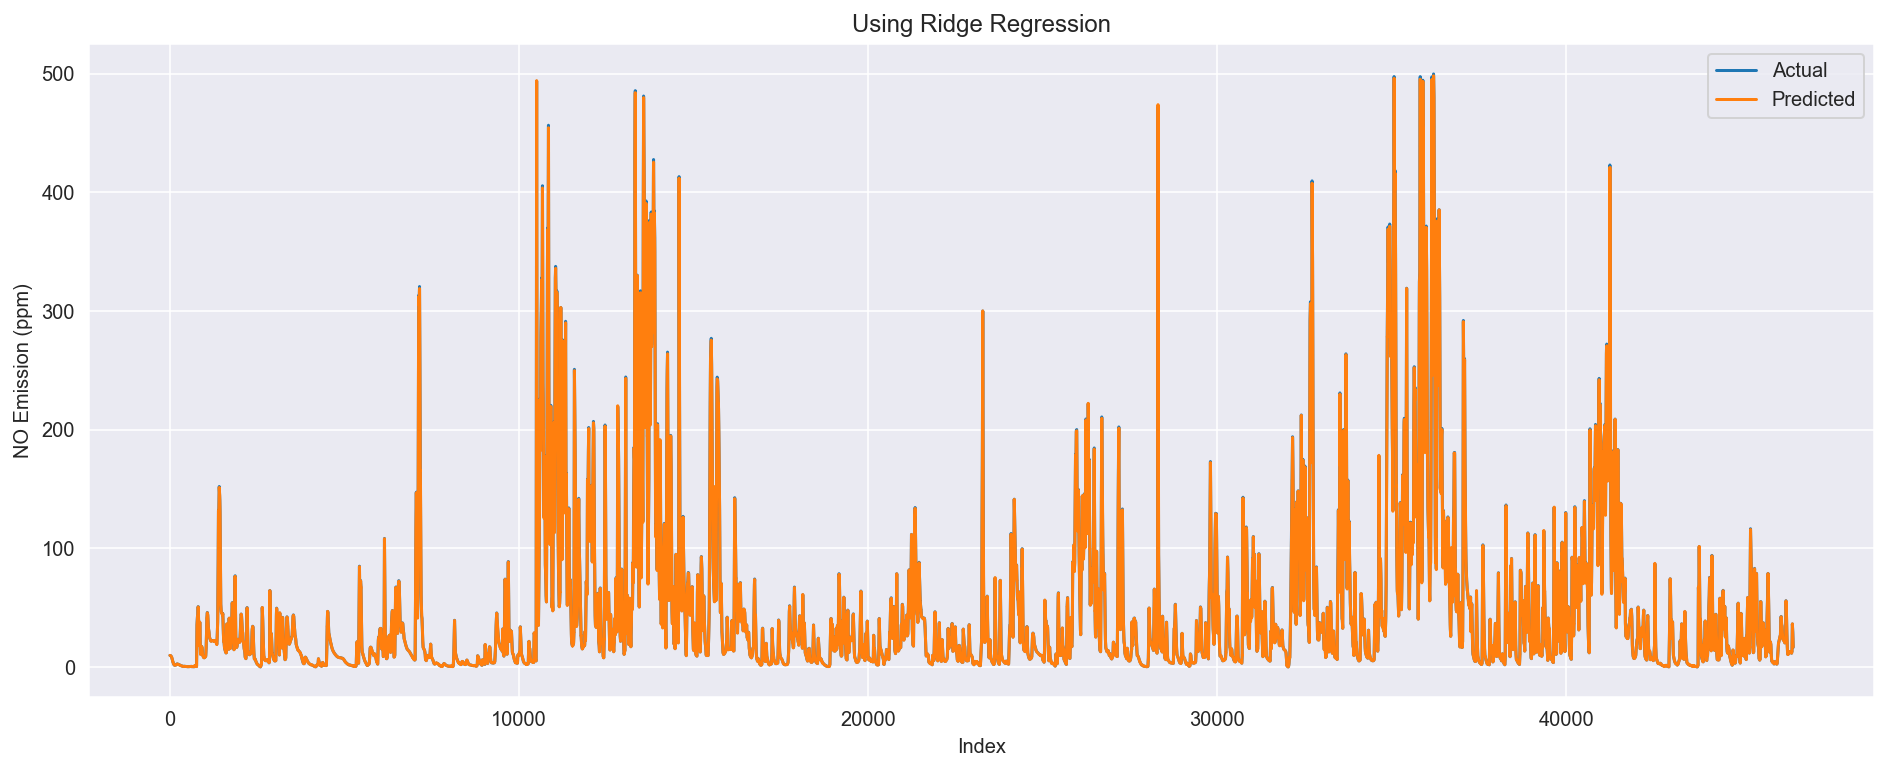

In [25]:
# Call Ridge Regression model
prediction, MSE['RidgeRegression'], MAE['RidgeRegression'], test = RidgeRegression(values, n_lag, n_features,0)
print("MSE for Ridge Regression method: " + str(MSE['RidgeRegression']))
print("MAE for Ridge Regression method: " + str(MAE['RidgeRegression']))
plot(test, prediction, 'Using Ridge Regression')

<AxesSubplot:>

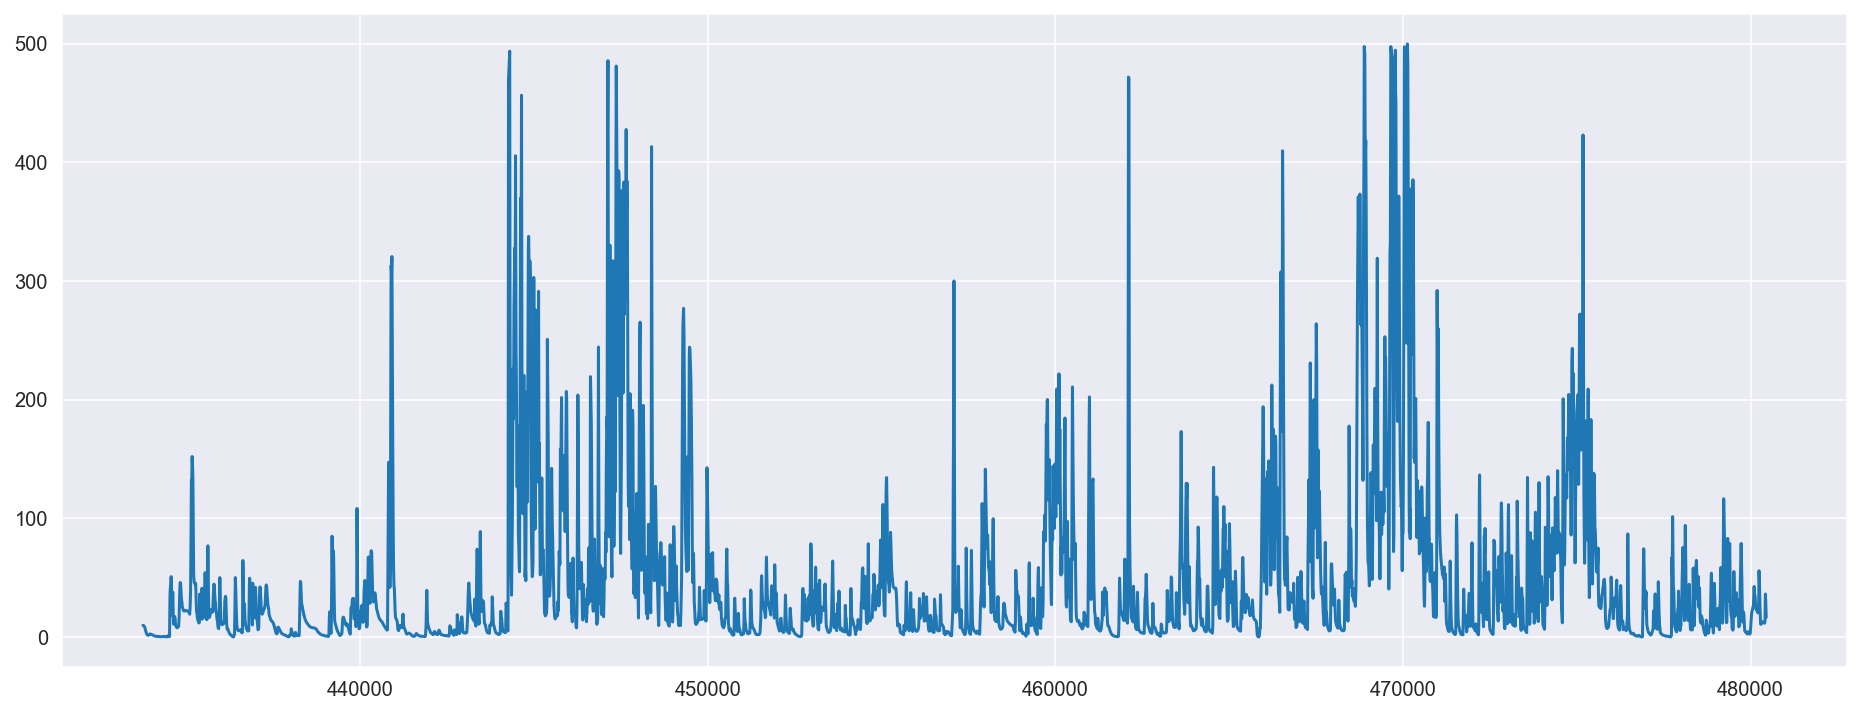

In [26]:
test_size = len(df) - int(train_percent*(len(df)))
df[-test_size:]['GPiS_NO'].plot()

### Downsample prediction

In [27]:
d = pd.DataFrame(columns=['test','pred'])
d.test = test
d.pred = prediction
d.shape

(46497, 2)

<AxesSubplot:>

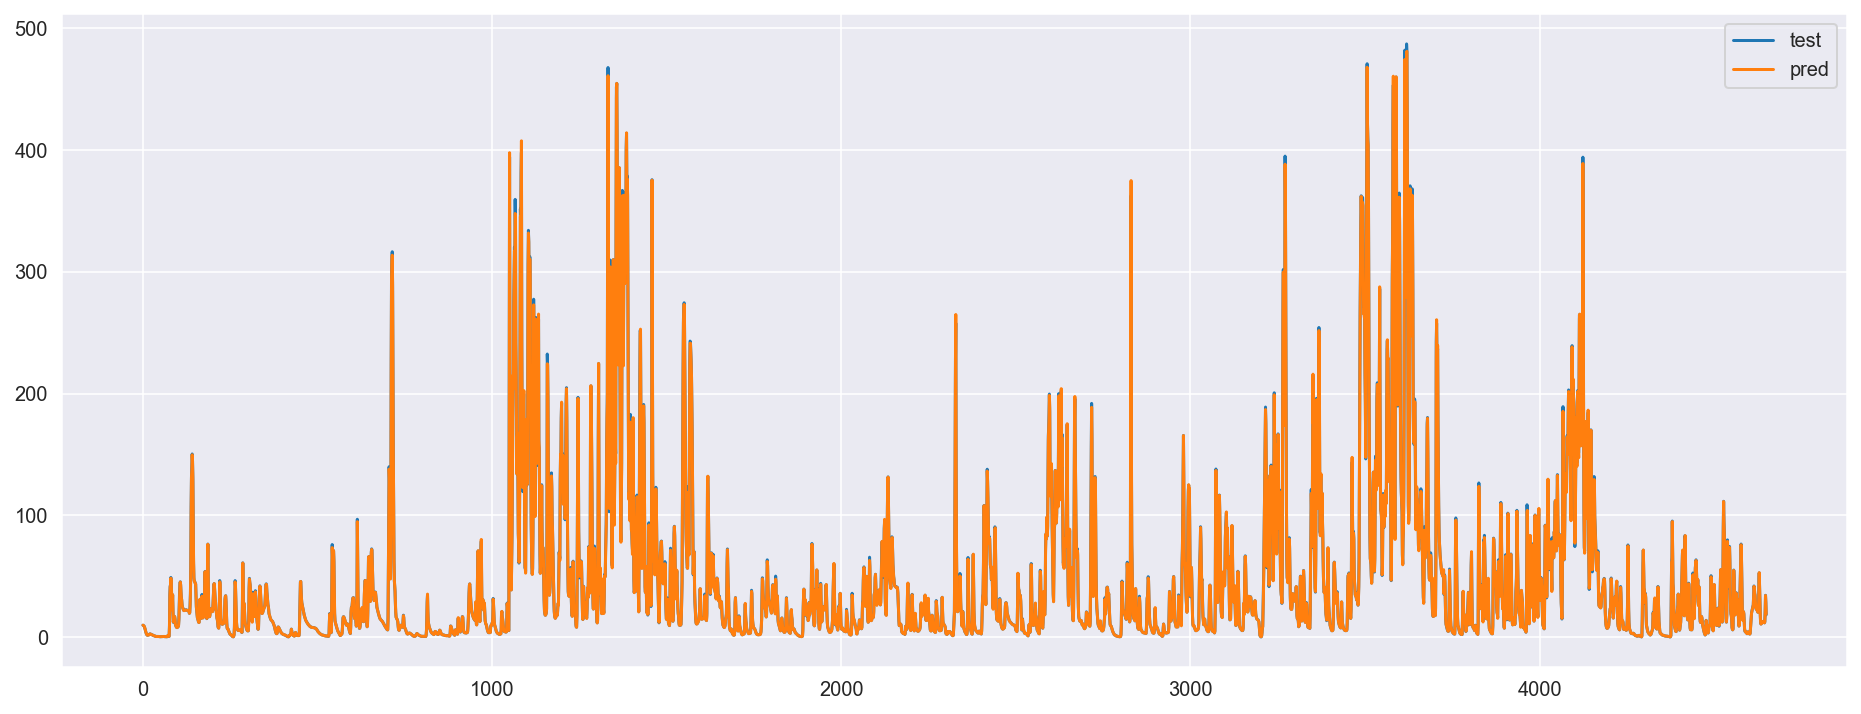

In [28]:
reduce_by = 10
d_down = d.groupby(d.index//reduce_by).mean()
d_down.plot()

In [29]:
print('Downsample RMSE : ' , mean_squared_error(d.pred, d.test))

Downsample RMSE :  7.6468515


## Downsample Complete data to 1 Hz

In [30]:
reduce_by = 10
df_down = df.groupby(df.index//reduce_by).mean()
df_down

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
0,0.590354,31.838507,962.795439,21.128718,18.000000,14.903600,20.0,0.000,0.0,0.000
1,0.610530,31.782788,962.746987,21.079297,17.933900,14.903600,20.0,0.000,0.0,0.000
2,0.581145,31.828817,962.771206,21.125812,17.898300,14.903600,20.0,0.000,0.0,0.000
3,0.445150,31.794901,962.771206,21.111276,17.817800,14.903600,20.0,0.000,0.0,0.000
4,0.355401,31.823972,962.795439,21.157789,17.916100,14.903600,20.0,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...
48041,14.344133,42.251205,976.916122,-4.873086,68.999000,23.643630,95.0,1446.825,18.7,0.000
48042,31.095189,42.260742,976.868439,-4.873086,68.509602,27.995940,95.0,1395.150,20.3,0.108
48043,31.853884,42.317959,976.939960,-4.870225,67.307000,27.407790,95.0,1307.125,23.8,0.108
48044,22.151866,42.346568,976.868439,-4.873086,67.794600,17.879761,95.0,1226.475,26.2,0.036


In [31]:
# tsplot(df_down['GPiS_NO'], title='NO Emission', lags=36);

(42093, 25) 42093 (42093,)
(4674, 25)
MSE for Linear Regression method: 436.1211016862764
MAE for Linear Regression method: 9.776827601774357


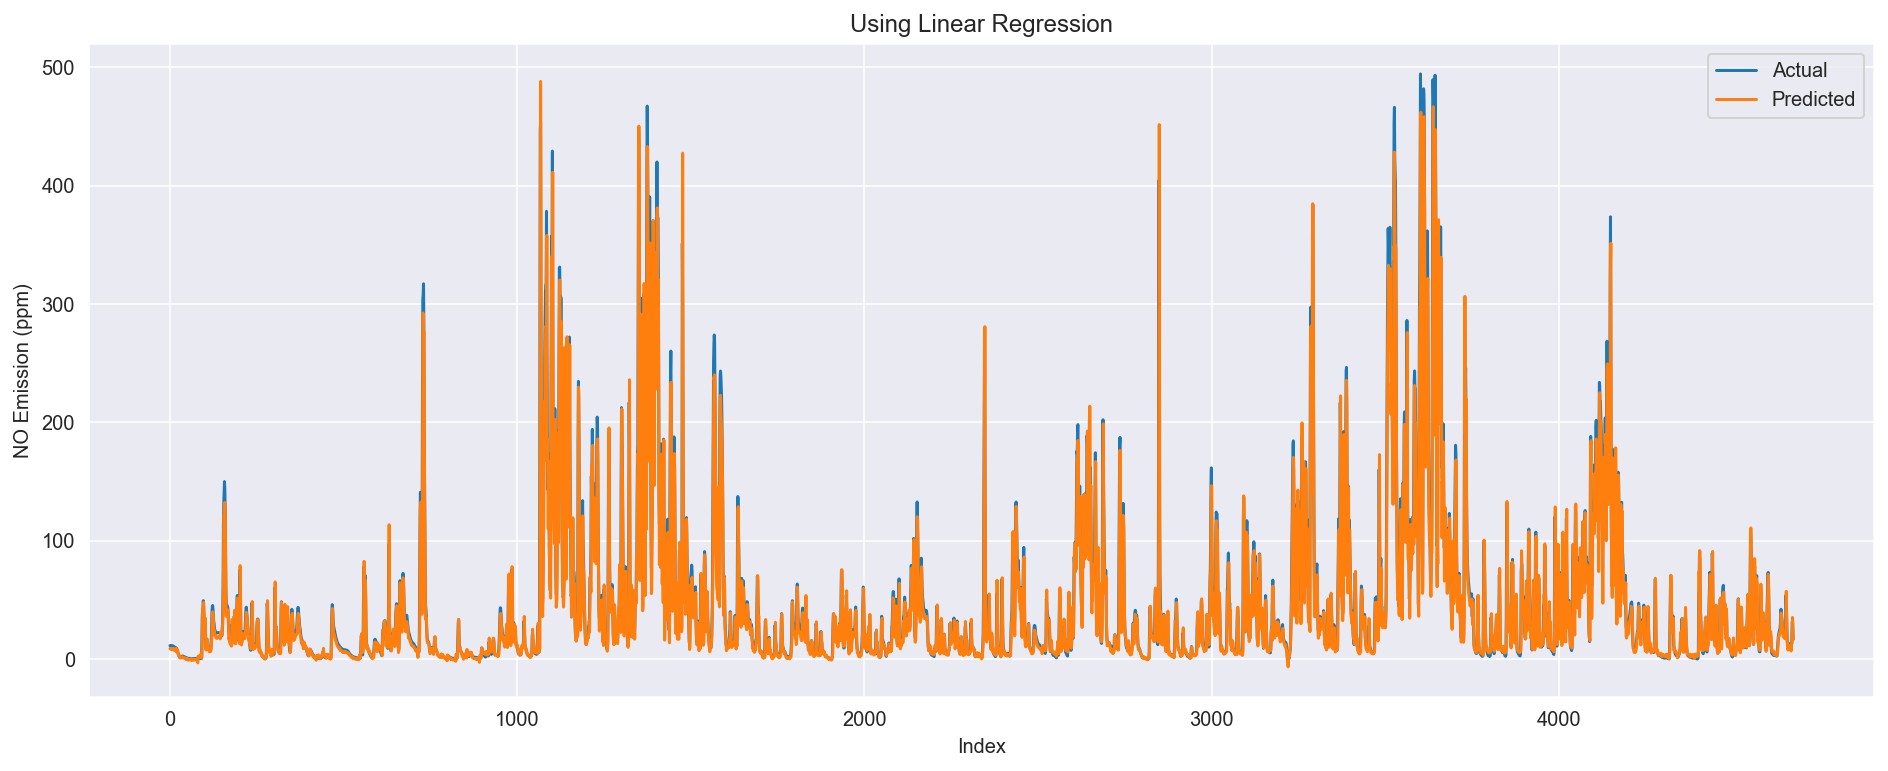

In [32]:
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(df_down.values, n_lag, n_features,0)
print("MSE for Linear Regression method: " + str(MSE['LinearRegression']))
print("MAE for Linear Regression method: " + str(MAE['LinearRegression']))
plot(test, prediction, 'Using Linear Regression')

In [33]:
from statsmodels.tsa.stattools import adfuller

X = df_down['GPiS_NO'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.176370
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [34]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(1000).mean()   
    rolstd = timeseries.rolling(1000).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

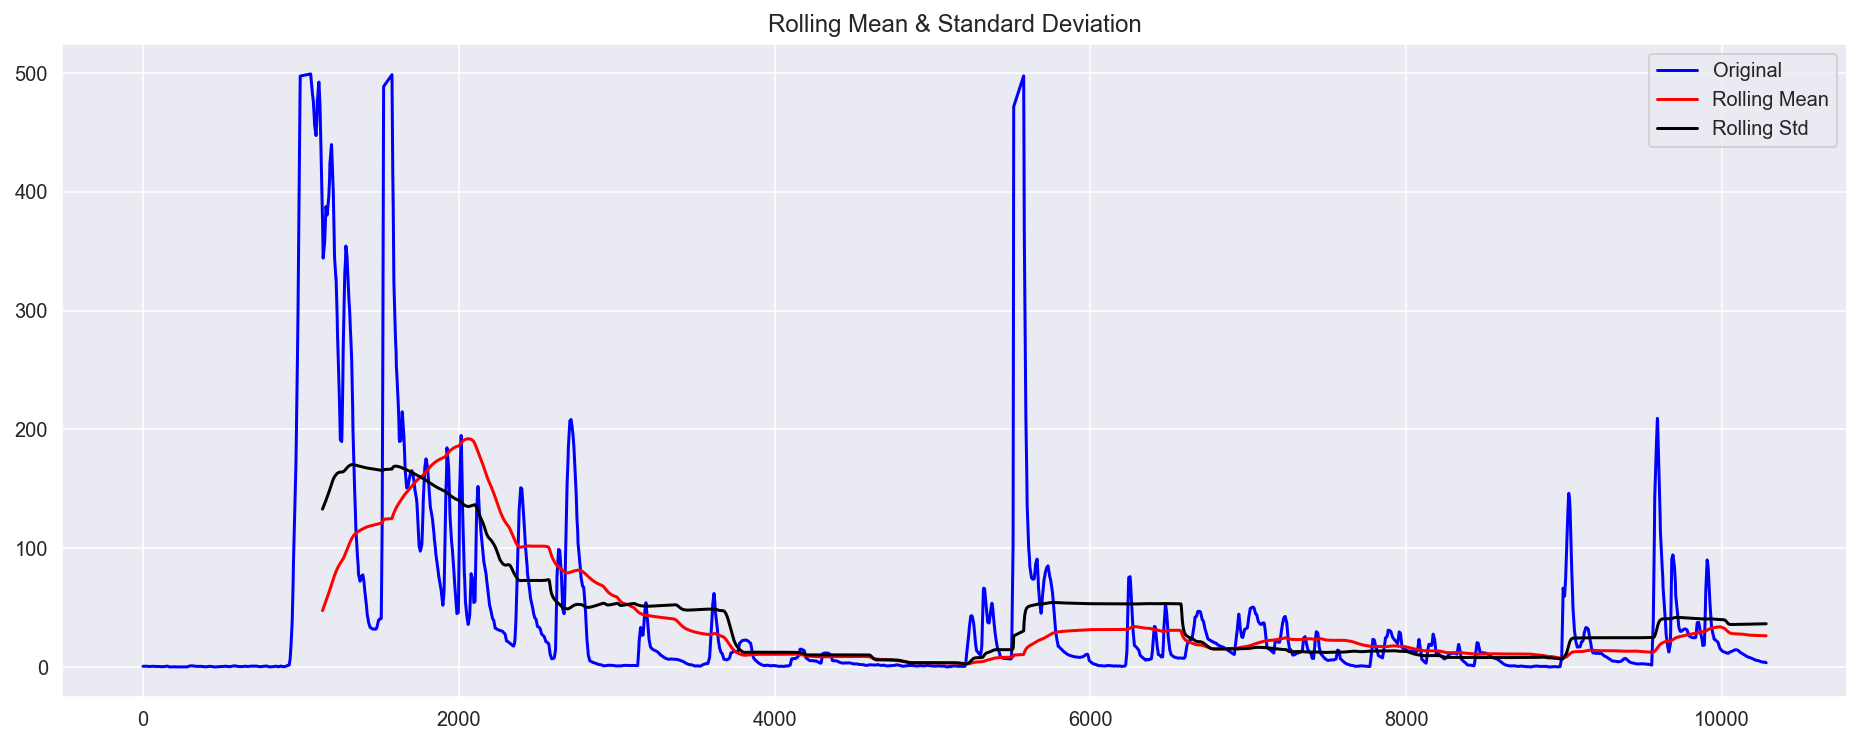

In [35]:
test_stationarity(df['GPiS_NO'][:10000])

In [36]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df['GPiS_NO'].values)

KPSS Statistic: 14.230467565574047
p-value: 0.01
num lags: 100
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [37]:
# from statsmodels.tsa.stattools import adfuller

# X = df['GPiS_NO'].values
# result = adfuller(X)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [38]:
kpss_test(df['GPiS_NO'].diff().dropna().values)

KPSS Statistic: 0.0002206850128420043
p-value: 0.1
num lags: 100
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


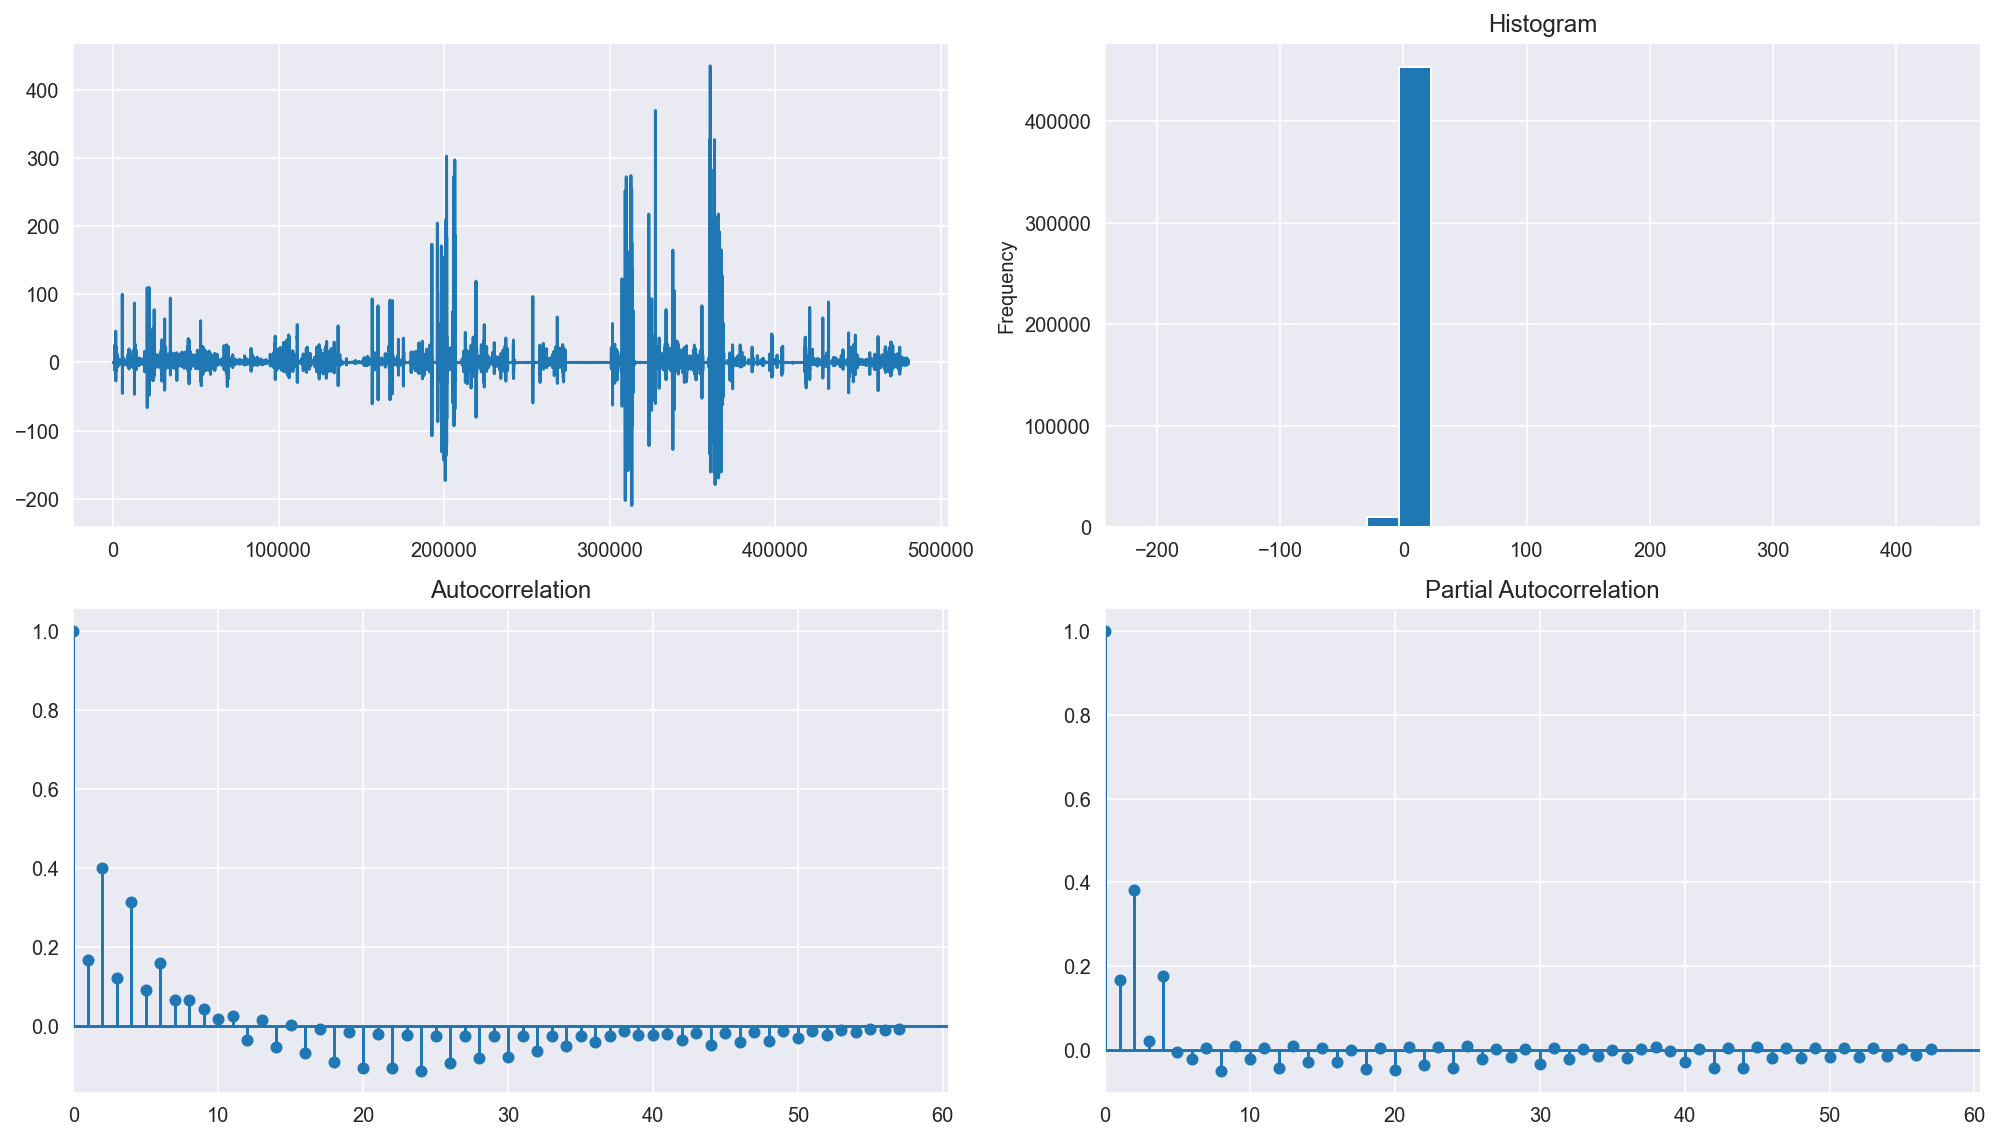

In [39]:
tsplot(df['GPiS_NO'].diff().dropna());

In [40]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

(418495, 25) 418495 (418495,)
(46497, 25)
(418496, 25) 418496 (418496,)
(46497, 25)


<AxesSubplot:>

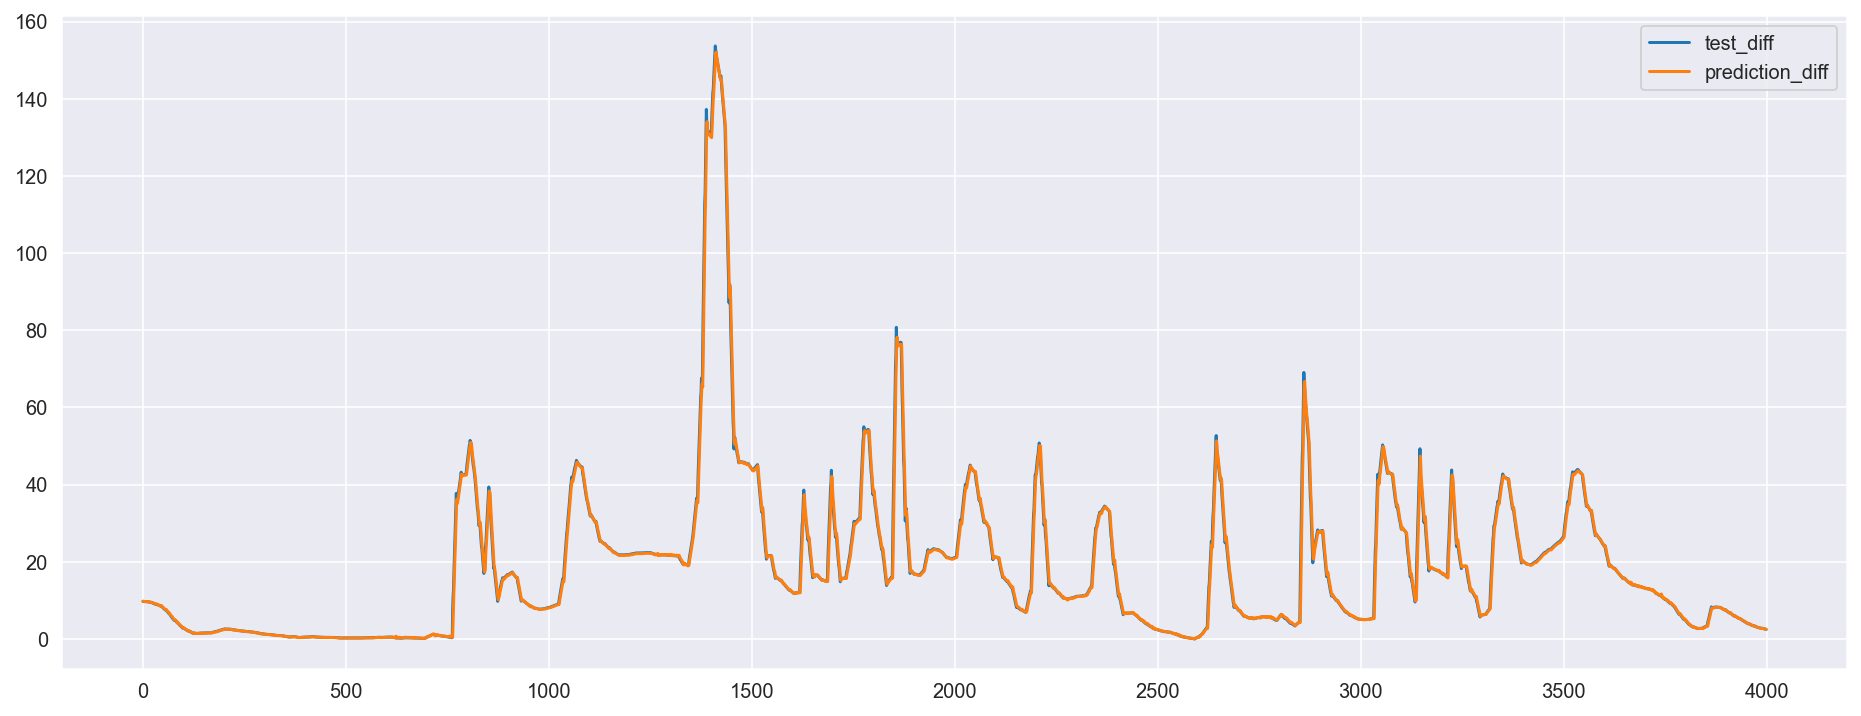

In [41]:
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(df.diff().dropna().values, n_lag, n_features,0)
prediction_, MSE['RidgeRegression'], MAE['RidgeRegression'], test_ = RidgeRegression(df.dropna().values, n_lag, n_features,0)

# invert the difference
test_diff = [inverse_difference(test_[i], test[i]) for i in range(len(test))]
prediction_diff = [inverse_difference(prediction_[i], prediction[i]) for i in range(len(prediction))]
diff = pd.DataFrame(columns=['test_diff','prediction_diff'])
diff.test_diff = test_diff
diff.prediction_diff = prediction_diff
diff.head(4000).plot()

In [42]:
# inverse diff
# cols = dd.columns
# x = []
# for col in cols:
#     diff_results = dd[col] + ddiff[col].shift(-1)
#     x.append(diff_results)
# diff_df_inverted = pd.concat(x, axis=1)

# diff_df_inverted.head(100).plot()

(418495, 25) 418495 (418495,)
(46497, 25)
(418495, 25) 418495 (418495,)
(46497, 25)
(418495, 25) 418495 (418495,)
(46497, 25)


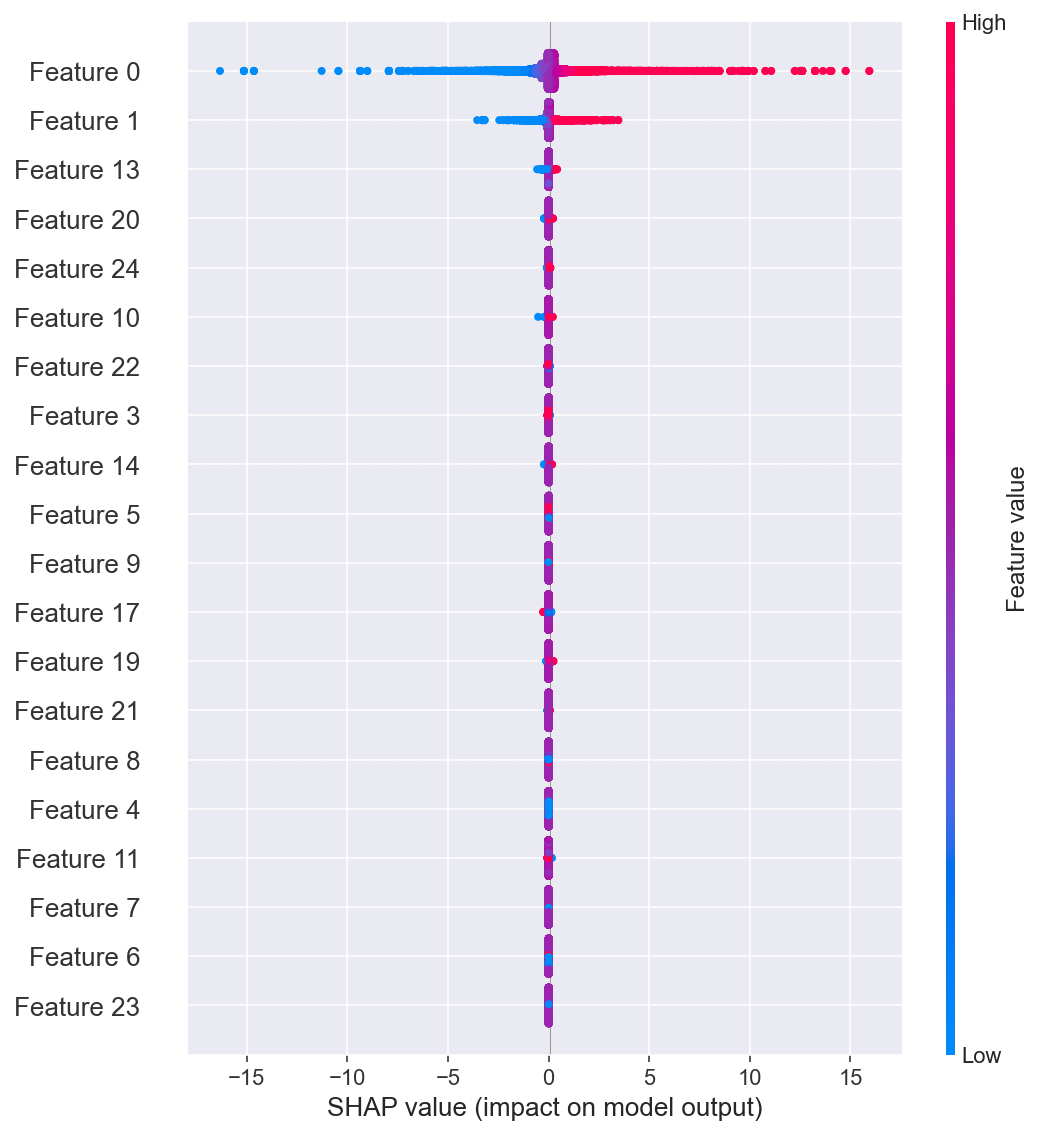

In [43]:
# Interpretation
def LinearReg1(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y, model,train_X,test_X

model = LinearReg1(df.diff().dropna().values, n_lag, n_features,0)[4]
train_X = LinearReg1(df.diff().dropna().values, n_lag, n_features,0)[5]
test_X = LinearReg1(df.diff().dropna().values, n_lag, n_features,0)[6]

import shap
explainer  = shap.LinearExplainer(model,train_X)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

In [44]:
d_100 = df[(df['GPiS_NO']<500) &(df['GPiS_NO']>0)][:-2000]

In [45]:
def LinearReg11(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

   var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)   var3(t-2)  \
3   0.593300   0.595300  31.918452  31.894226  31.845775  962.843895   
4   0.595300   0.596975  31.894226  31.845775  31.773098  962.843895   
5   0.596975   0.598475  31.845775  31.773098  31.797323  962.843895   
6   0.598475   0.600300  31.773098  31.797323  31.845775  962.601614   
7   0.600300   0.602300  31.797323  31.845775  31.821549  962.843895   

    var3(t-1)  var4(t-3)  var4(t-2)  var4(t-1)  var5(t-2)  var5(t-1)  \
3  962.843895  21.181047  21.151974  21.122906  18.100000  18.100000   
4  962.843895  21.151974  21.122906  21.093832  18.100000  18.100000   
5  962.601614  21.122906  21.093832  21.122906  18.100000  18.100000   
6  962.843895  21.093832  21.122906  21.093832  18.100000  18.021999   
7  962.843895  21.122906  21.093832  21.181047  18.021999  17.900000   

   var6(t-3)  var6(t-2)  var6(t-1)  var7(t-2)  var7(t-1)  var8(t-3)  \
3    14.9036    14.9036    14.9036       20.0       20.0       

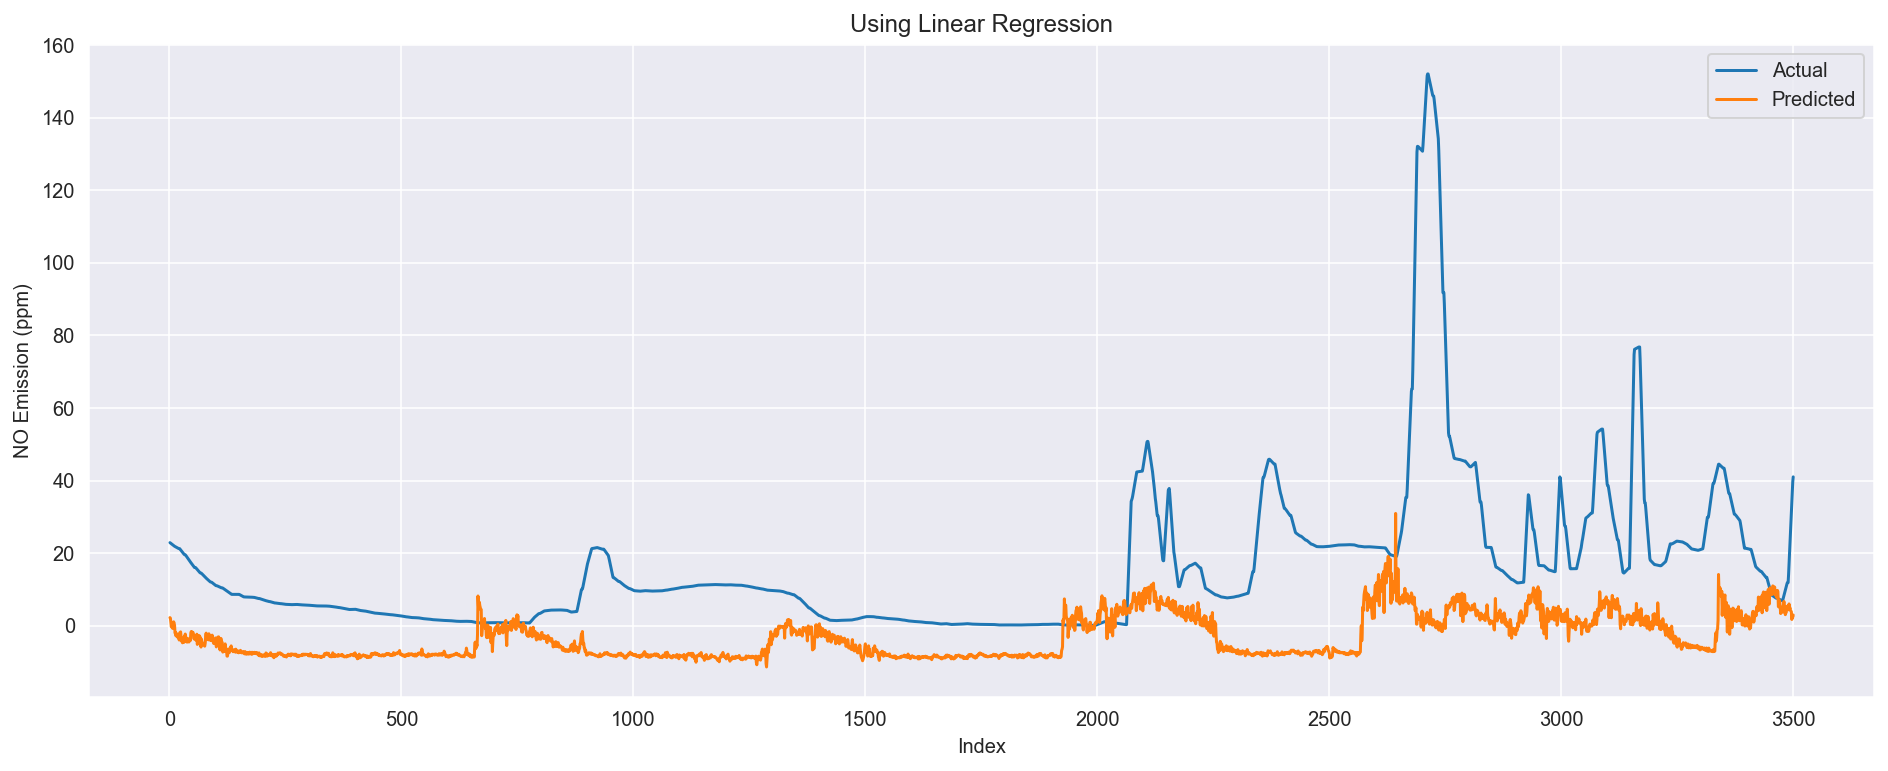

In [46]:
prediction, MSE['LinearRegression'],test, model = LinearReg11(d_100.dropna().values, n_lag, n_features,1)
print("RMSE for Linear Regression method: " + str(MSE['LinearRegression']))
plot(test[500:4000], prediction[500:4000], 'Using Linear Regression')

# # invert the difference
# test_diff = [inverse_difference(test_[i], test[i]) for i in range(len(test))]
# prediction_diff = [inverse_difference(prediction_[i], prediction[i]) for i in range(len(prediction))]
# diff = pd.DataFrame(columns=['test_diff','prediction_diff'])
# diff.test_diff = test_diff
# diff.prediction_diff = prediction_diff
# diff.plot()

In [47]:
d_100.head()

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
0,0.514287,31.845775,962.843895,21.151974,17.900000,14.9036,20.0,0.0,0.0,NaN
1,0.592000,31.918452,962.843895,21.181047,17.978001,14.9036,20.0,0.0,0.0,0.0
2,0.593300,31.894226,962.843895,21.151974,18.100000,14.9036,20.0,0.0,0.0,0.0
3,0.595300,31.845775,962.843895,21.122906,18.100000,14.9036,20.0,0.0,0.0,0.0
4,0.596975,31.773098,962.843895,21.093832,18.100000,14.9036,20.0,0.0,0.0,0.0


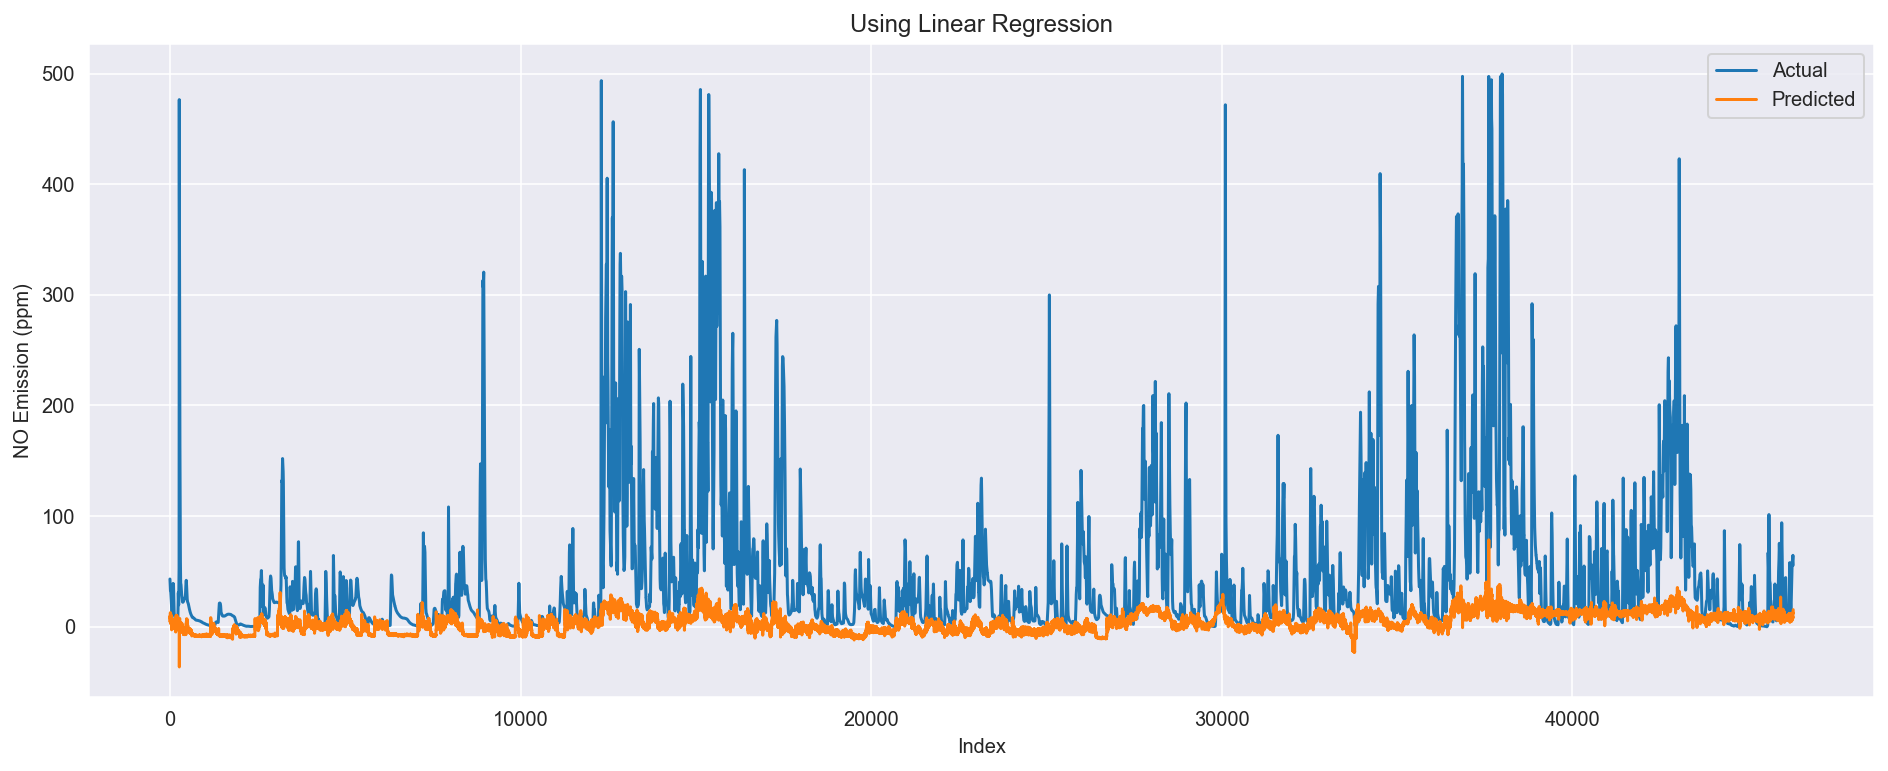

In [48]:
plot(test, prediction, 'Using Linear Regression')

(416696, 25) 416696 (416696,)
(46297, 25)
(416696, 25) 416696 (416696,)
(46297, 25)
(416696, 25) 416696 (416696,)
(46297, 25)


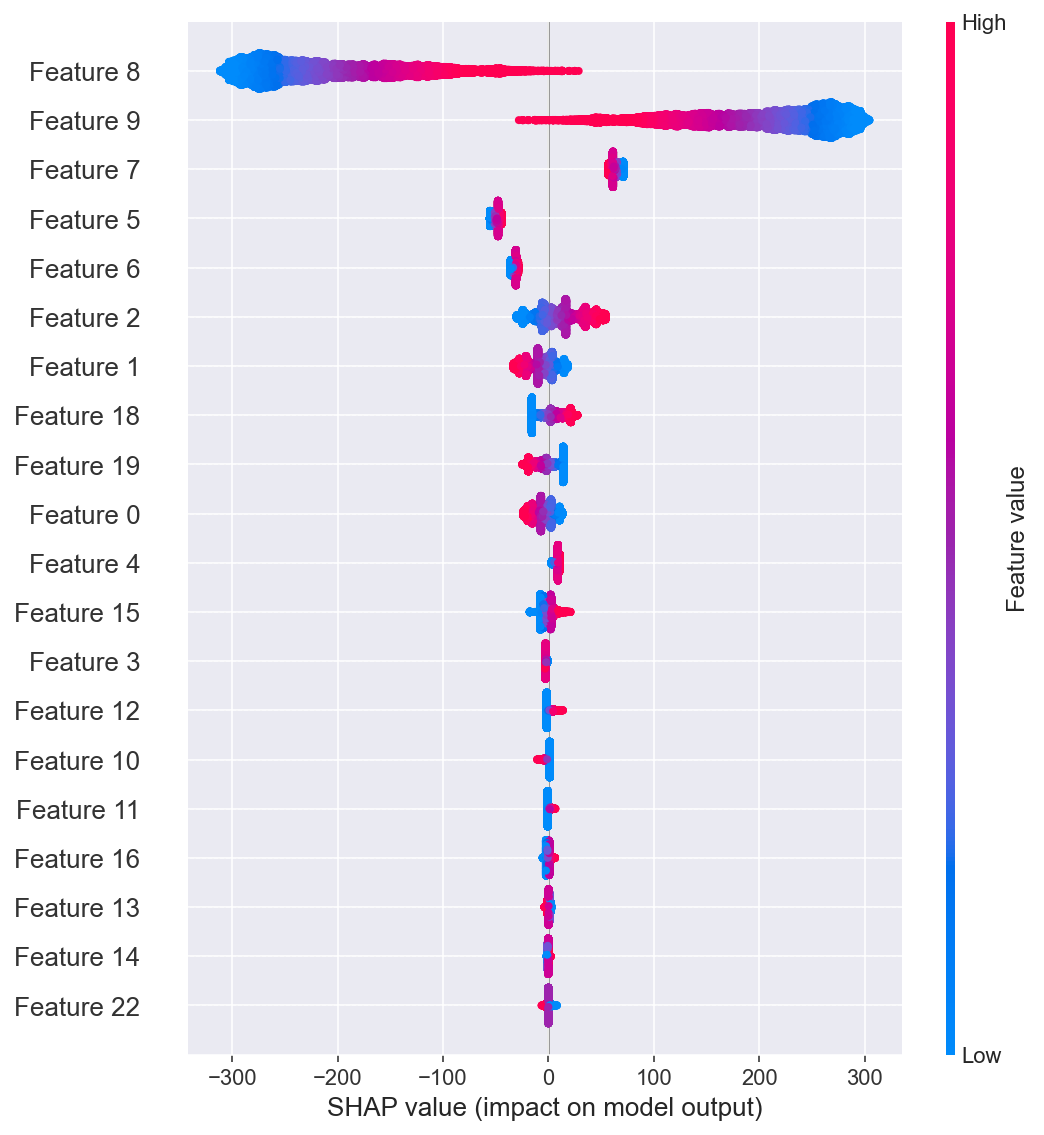

In [49]:
# Interpretation
def LinearReg12(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y, model,train_X,test_X

model = LinearReg12(d_100.dropna().values, n_lag, n_features,0)[4]
train_X = LinearReg12(d_100.dropna().values, n_lag, n_features,0)[5]
test_X = LinearReg12(d_100.dropna().values, n_lag, n_features,0)[6]

import shap
explainer  = shap.LinearExplainer(model,train_X)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

In [50]:
# # Implementing Huber_Regressor method
# def Huber_Regressor(data, n_lag, n_features,flag):
#     # Fit Huber_Regressor 
#     train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
#     # include or exclude NO
#     train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
#     test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
#     print("new_train shape :",len(train_X[0]))
#     model = HuberRegressor()
#     model.fit(train_X, train_y)
#     prediction = model.predict(test_X)
#     rmse = np.sqrt(mean_squared_error(prediction, test_y))
#     return prediction, rmse,test_y, model

In [51]:
# prediction, MSE['Huber_Regressor'],test, model = Huber_Regressor(d_100.dropna().values, n_lag, n_features,0)
# print("RMSE for Huber_Regressor method: " + str(MSE['Huber_Regressor']))
# plot(test, prediction, 'Using Huber_Regressor')

(416695, 25) 416695 (416695,)
(46297, 25)
new_train shape : 23
RMSE for Linear Regression method: 3.246540644230829


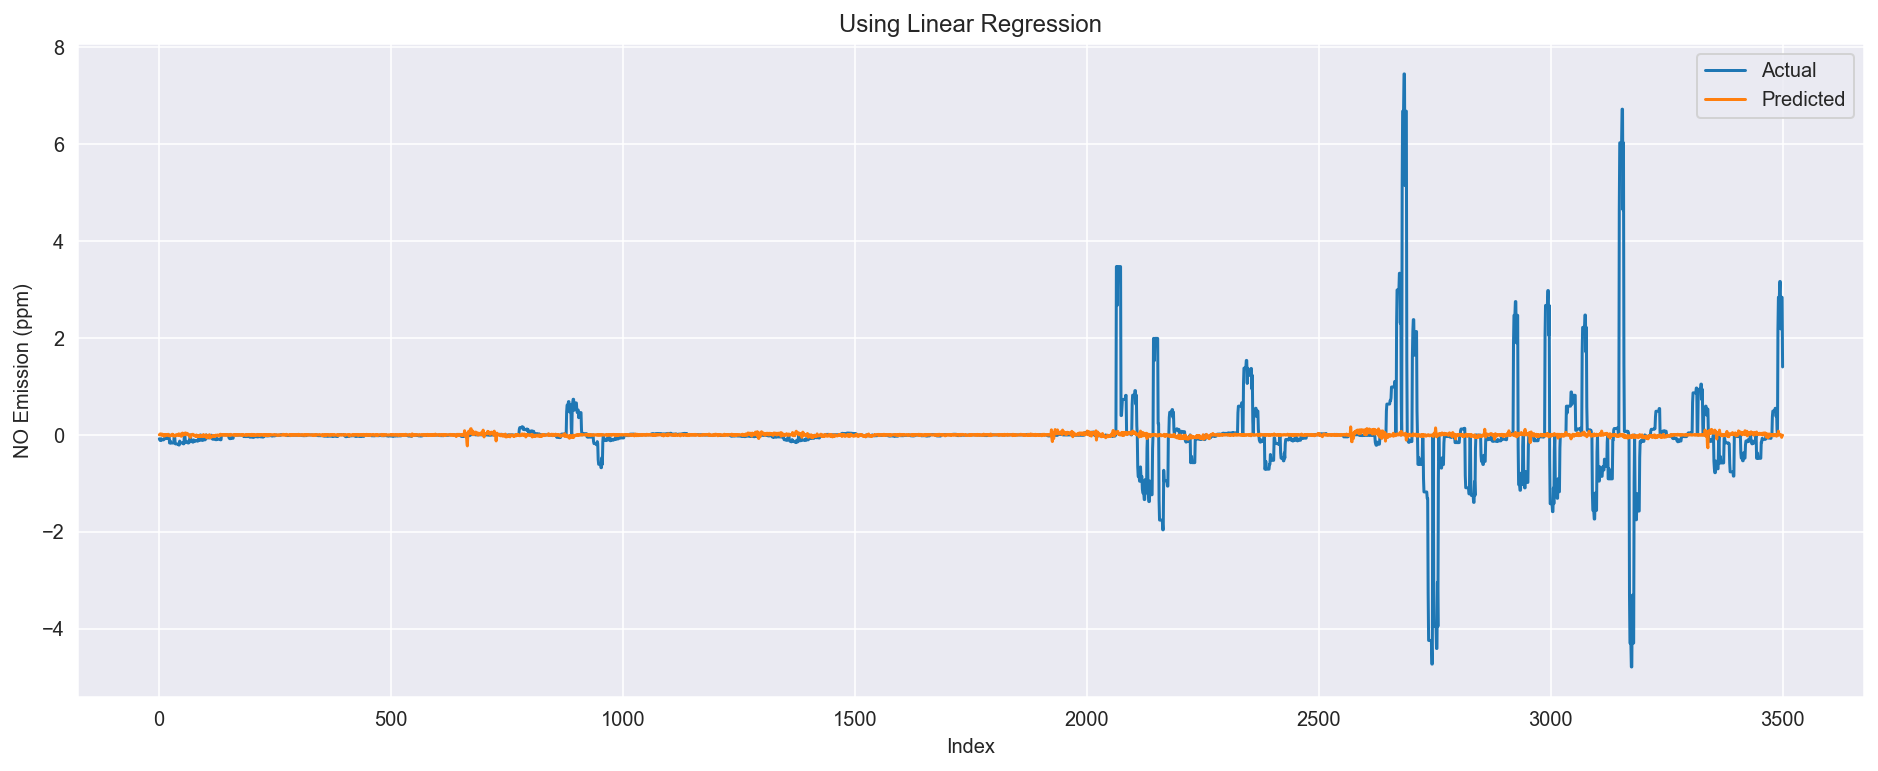

In [52]:
prediction_diff, MSE['LinearRegression'],test_diff, model_diff = LinearReg11(d_100.diff().dropna().values, n_lag, n_features,0)
print("RMSE for Linear Regression method: " + str(MSE['LinearRegression']))
plot(test_diff[500:4000], prediction_diff[500:4000], 'Using Linear Regression')